# Digit Recognizer (unsupervised learning)

### Challenge Problem:
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this analysis, the goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.
Although it has labels, it aims to categorize them by multiple unsupervised learning techniques.


In [2]:
!pip install -q opendatasets

import opendatasets as od
import pandas as pd


In [3]:
from google.colab import drive
drive.mount('./gdrive')


Mounted at ./gdrive


In [4]:
od.download('https://www.kaggle.com/competitions/digit-recognizer/data') # insert  kaggle  username and key


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asukasaito
Your Kaggle Key: ··········


100%|██████████| 15.3M/15.3M [00:00<00:00, 84.2MB/s]



Extracting archive ./digit-recognizer/digit-recognizer.zip to ./digit-recognizer


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image


### Data Description:

The dataset consists of  pixel pathology images. The data set features are;
*   Test data size: 51MB, 28,000 rows
*   Train data size: 76MB, 42,000 rows
*   The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

Data set is avilable here.
https://www.kaggle.com/competitions/digit-recognizer/data





In [6]:


# Path to the training images and labels
train_path = '/content/digit-recognizer/train.csv'
test_path  = '/content/digit-recognizer/test.csv'
train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print(train.describe())


              label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
mean       0.0      0.0      0.0  ...      0.219286      0.117095   
std        0.0      0.0      0.0  ...      6.312890      4.633819   
min        0.0      0.0      0

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score


#Exploratory Data Analysis


###Data Set Overview
* The training dataset consists of 42,000 samples.
* There are 10 unique labels corresponding to the digits 0 through 9.
* The distribution of these labels is fairly uniform, with approximately 4,000 instances per digit. The accompanying bar chart illustrates this balance.
* Sample images from the dataset are displayed below, showcasing the diversity in handwriting styles.
* Pixel intensity analysis reveals a bimodal distribution, with most pixels being either 0 (black) or 255 (white), indicating that images are typically high-contrast with a clear distinction between the digit and the background.
###Data Cleaning and Preprocessing
* An examination for missing values was conducted. While missing data is not typically expected in image datasets, confirming their absence ensures the quality of our analysis.
* Pixel values were standardized to have a mean of zero and a standard deviation of one. This normalization is vital for clustering algorithms, particularly K-Means, which relies on distance metrics that are sensitive to the scale of the data.
* To address the high dimensionality of the data, Principal Component Analysis (PCA) was performed, reducing the feature set to preserve 95% of the data variance. This dimensionality reduction aids in simplifying the dataset and enhancing the performance of clustering algorithms.
* I also explored the t-distributed Stochastic Neighbor Embedding (t-SNE) transformation, which is a powerful technique for visualizing high-dimensional data.
###Distribution and Outliers
* The distribution of digit labels was analyzed, and no outliers were detected. This uniformity is advantageous for unsupervised learning, as it implies that each digit class has sufficient representation.
###Initial Observations and Hypotheses
* Preliminary visualizations indicate that certain digits possess unique characteristics that make them easily distinguishable. In contrast, some digits share similar traits, which may pose a challenge for clustering.
* It is hypothesized that clustering algorithms will more effectively differentiate between digits with unique shapes, such as '1' and '0', whereas digits with structural similarities, such as '4' and '9', may be more challenging to discern accurately.


In [8]:

# Dropping the 'label' column for unsupervised learning
X_train = train.drop("label", axis=1)
y_train = train["label"]

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test)

X_train_255 = X_train/ 255
X_test_255 = test/ 255


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


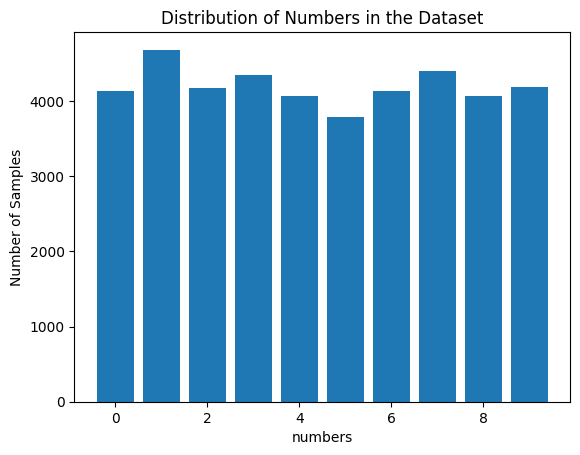

In [9]:
# Count the occurrences of each class
class_counts = train['label'].value_counts()
print(class_counts)

# Creating the histogram
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('numbers')
plt.ylabel('Number of Samples')
plt.title('Distribution of Numbers in the Dataset')
plt.show()


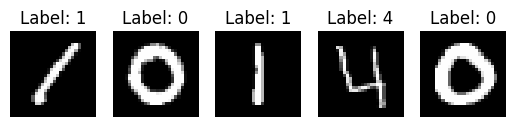

In [10]:

# Reshape the images and plot them
for i in range(5):
    image = train.iloc[i, 1:].values.reshape(28, 28)  # Reshape from 1D to 2D
    plt.subplot(1, 5, i+1)  # Create subplots for each image
    plt.imshow(image, cmap='gray')  # Show the image in grayscale
    plt.title(f"Label: {train.iloc[i, 0]}")  # Show the label of the image
    plt.axis('off')  # Turn off the axis

plt.show()  # Display the images


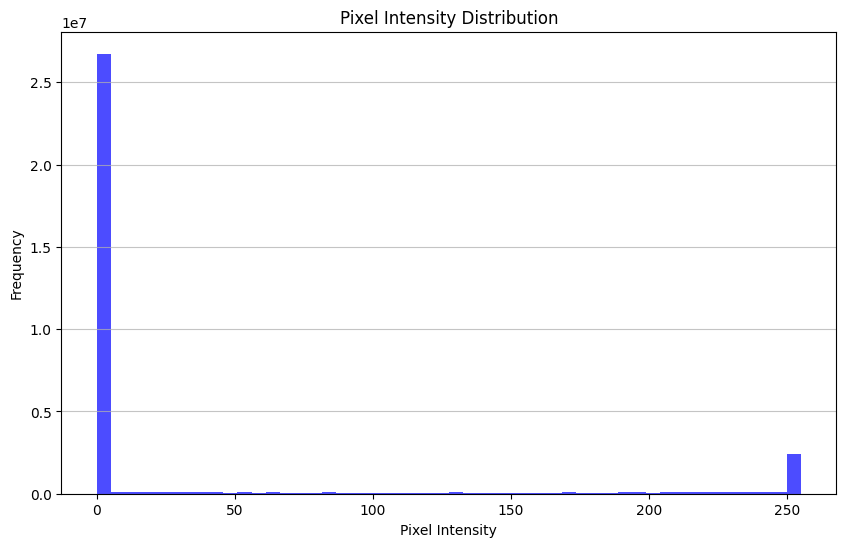

In [11]:

# Extract all pixel values (excluding the label column)
pixels = train.iloc[:, 1:].values.flatten()  # Flatten to make a 1D array

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(pixels, bins=50, color='blue', alpha=0.7)  # Create the histogram
plt.title('Pixel Intensity Distribution')  # Title of the histogram
plt.xlabel('Pixel Intensity')  # Label for x-axis
plt.ylabel('Frequency')  # Label for y-axis
plt.grid(axis='y', alpha=0.75)  # Add a grid for better readability

plt.show()  # Display the histogram


In [12]:
# Optional: Reducing dimensionality with PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Now your data is preprocessed and ready for clustering
tsne = TSNE(n_components=2, random_state=0,verbose = 1)
X_train_tsne = tsne.fit_transform(X_train_scaled)  # Or X_train_scaled
X_test_tsne = tsne.fit_transform(X_test_scaled)  # Or X_train_scaled

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 42000 samples in 0.153s...
[t-SNE] Computed neighbors for 42000 samples in 25.325s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42000
[t-SNE] Computed conditional probabilities for sample 2000 / 42000
[t-SNE] Computed conditional probabilities for sample 3000 / 42000
[t-SNE] Computed conditional probabilities for sample 4000 / 42000
[t-SNE] Computed conditional probabilities for sample 5000 / 42000
[t-SNE] Computed conditional probabilities for sample 6000 / 42000
[t-SNE] Computed conditional probabilities for sample 7000 / 42000
[t-SNE] Computed conditional probabilities for sample 8000 / 42000
[t-SNE] Computed conditional probabilities for sample 9000 / 42000
[t-SNE] Computed conditional probabilities for sample 10000 / 42000
[t-SNE] Computed conditional probabilities for sample 11000 / 42000
[t-SNE] Computed conditional probabilities for sample 12000 / 42000
[t-SNE] Computed conditional probabilities for sa

In [13]:
X_train_pca_255 = pca.fit_transform(X_train_255)
X_test_pca_255 = pca.transform(X_test_255)

X_train_tsne_255 = tsne.fit_transform(X_train_255)  # Or X_train_scaled
X_test_tsne_255 = tsne.fit_transform(X_test_255)  # Or X_train_scaled

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 42000 samples in 0.230s...
[t-SNE] Computed neighbors for 42000 samples in 25.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42000
[t-SNE] Computed conditional probabilities for sample 2000 / 42000
[t-SNE] Computed conditional probabilities for sample 3000 / 42000
[t-SNE] Computed conditional probabilities for sample 4000 / 42000
[t-SNE] Computed conditional probabilities for sample 5000 / 42000
[t-SNE] Computed conditional probabilities for sample 6000 / 42000
[t-SNE] Computed conditional probabilities for sample 7000 / 42000
[t-SNE] Computed conditional probabilities for sample 8000 / 42000
[t-SNE] Computed conditional probabilities for sample 9000 / 42000
[t-SNE] Computed conditional probabilities for sample 10000 / 42000
[t-SNE] Computed conditional probabilities for sample 11000 / 42000
[t-SNE] Computed conditional probabilities for sample 12000 / 42000
[t-SNE] Computed conditional probabilities for sa

In [14]:
len(X_test_tsne_255)

28000

# Analysis (Model Building and Training) and the result
* Transformations using PCA/t-SNE and scaling to 255 were performed. The resulting visualizations, as shown in the charts below, illustrate that t-SNE effectively distinguished several clusters, whereas PCA did not.
* Notably, the t-SNE transformation applied to data scaled to 255 revealed 10 distinct clusters, which aligns well with the 10 digit classes in the dataset.
* This clustering tendency was also observed within the test dataset. The t-SNE visualization of the scaled-to-255 data clearly depicted 10 clusters, reinforcing its appropriateness for the subsequent modeling phase.
* Given these observations, the t-SNE transformation with data scaled to 255 was chosen for the modeling process. Two clustering algorithms were investigated: K-Means and Gaussian Mixture Models (GMM).

* K-Means is a well-known clustering algorithm that partitions the data into K distinct clusters based on feature similarity. However, due to its assumption that clusters are spherical and equally sized, it may not always capture the true underlying patterns in more complex datasets.

* Gaussian Mixture Models (GMM), on the other hand, offer a more flexible clustering approach. GMM assumes that the data is generated from a mixture of several Gaussian distributions with unknown parameters. Unlike K-Means, GMM accommodates clusters that have different sizes and correlations, as well as the soft assignment of points to clusters. This probabilistic model can be particularly powerful when the true structure of the data is unknown or when the clusters are not clearly separable.

* Hyperparameter tuning for the Gaussian Mixture Model was conducted, with the number of components (clusters) ranging from 1 to 51, incrementing by steps of 5. The goal was to find the optimal balance between model complexity and predictive power.

* The evaluation of the models was based on accuracy. The GMM with 31 components yielded the highest accuracy of 96%. The accuracy increased steadily up to 31 components; however, beyond this number, from 36 to 51, the accuracy fluctuated around 85%.

* The results are further demonstrated in the confusion matrix provided below. This matrix offers a detailed breakdown of the model's performance, showing how often each actual digit was assigned to each cluster.

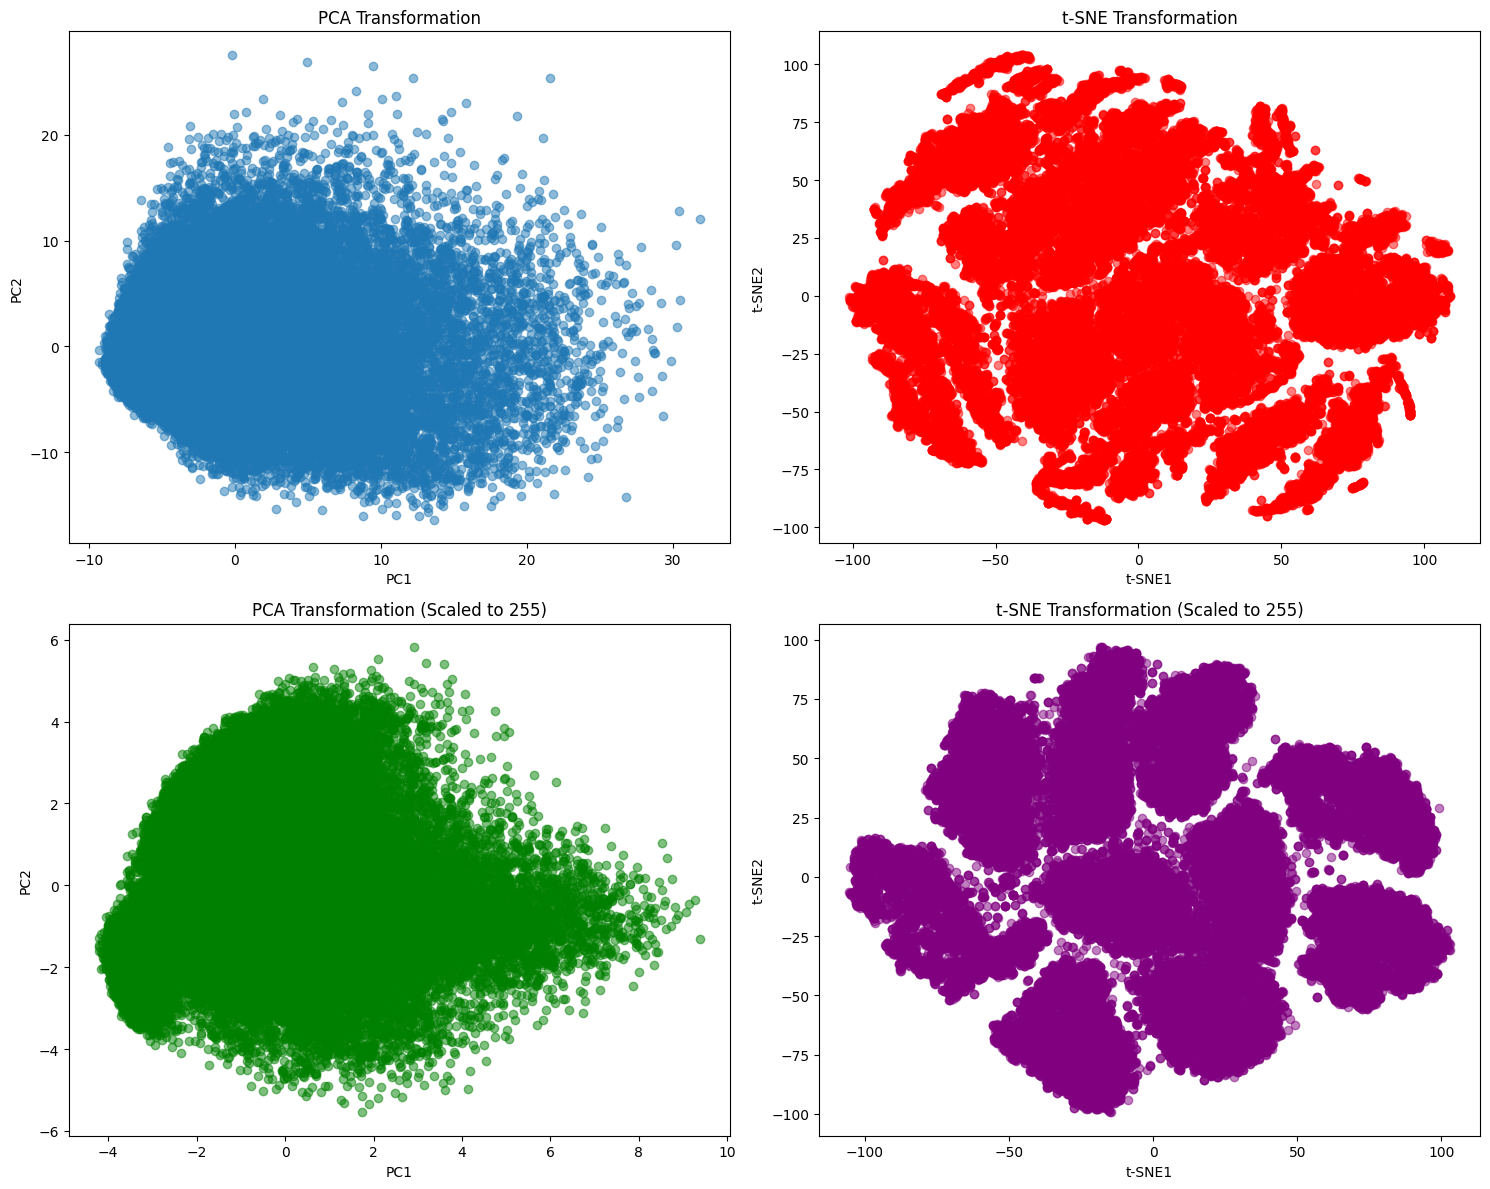

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# PCA without scaling to 255
axs[0, 0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
axs[0, 0].set_title('PCA Transformation')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')

# t-SNE without scaling to 255
axs[0, 1].scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.5, color='red')
axs[0, 1].set_title('t-SNE Transformation')
axs[0, 1].set_xlabel('t-SNE1')
axs[0, 1].set_ylabel('t-SNE2')

# PCA with scaling to 255
axs[1, 0].scatter(X_train_pca_255[:, 0], X_train_pca_255[:, 1], alpha=0.5, color='green')
axs[1, 0].set_title('PCA Transformation (Scaled to 255)')
axs[1, 0].set_xlabel('PC1')
axs[1, 0].set_ylabel('PC2')

# t-SNE with scaling to 255
axs[1, 1].scatter(X_train_tsne_255[:, 0], X_train_tsne_255[:, 1], alpha=0.5, color='purple')
axs[1, 1].set_title('t-SNE Transformation (Scaled to 255)')
axs[1, 1].set_xlabel('t-SNE1')
axs[1, 1].set_ylabel('t-SNE2')

plt.tight_layout()
plt.show()


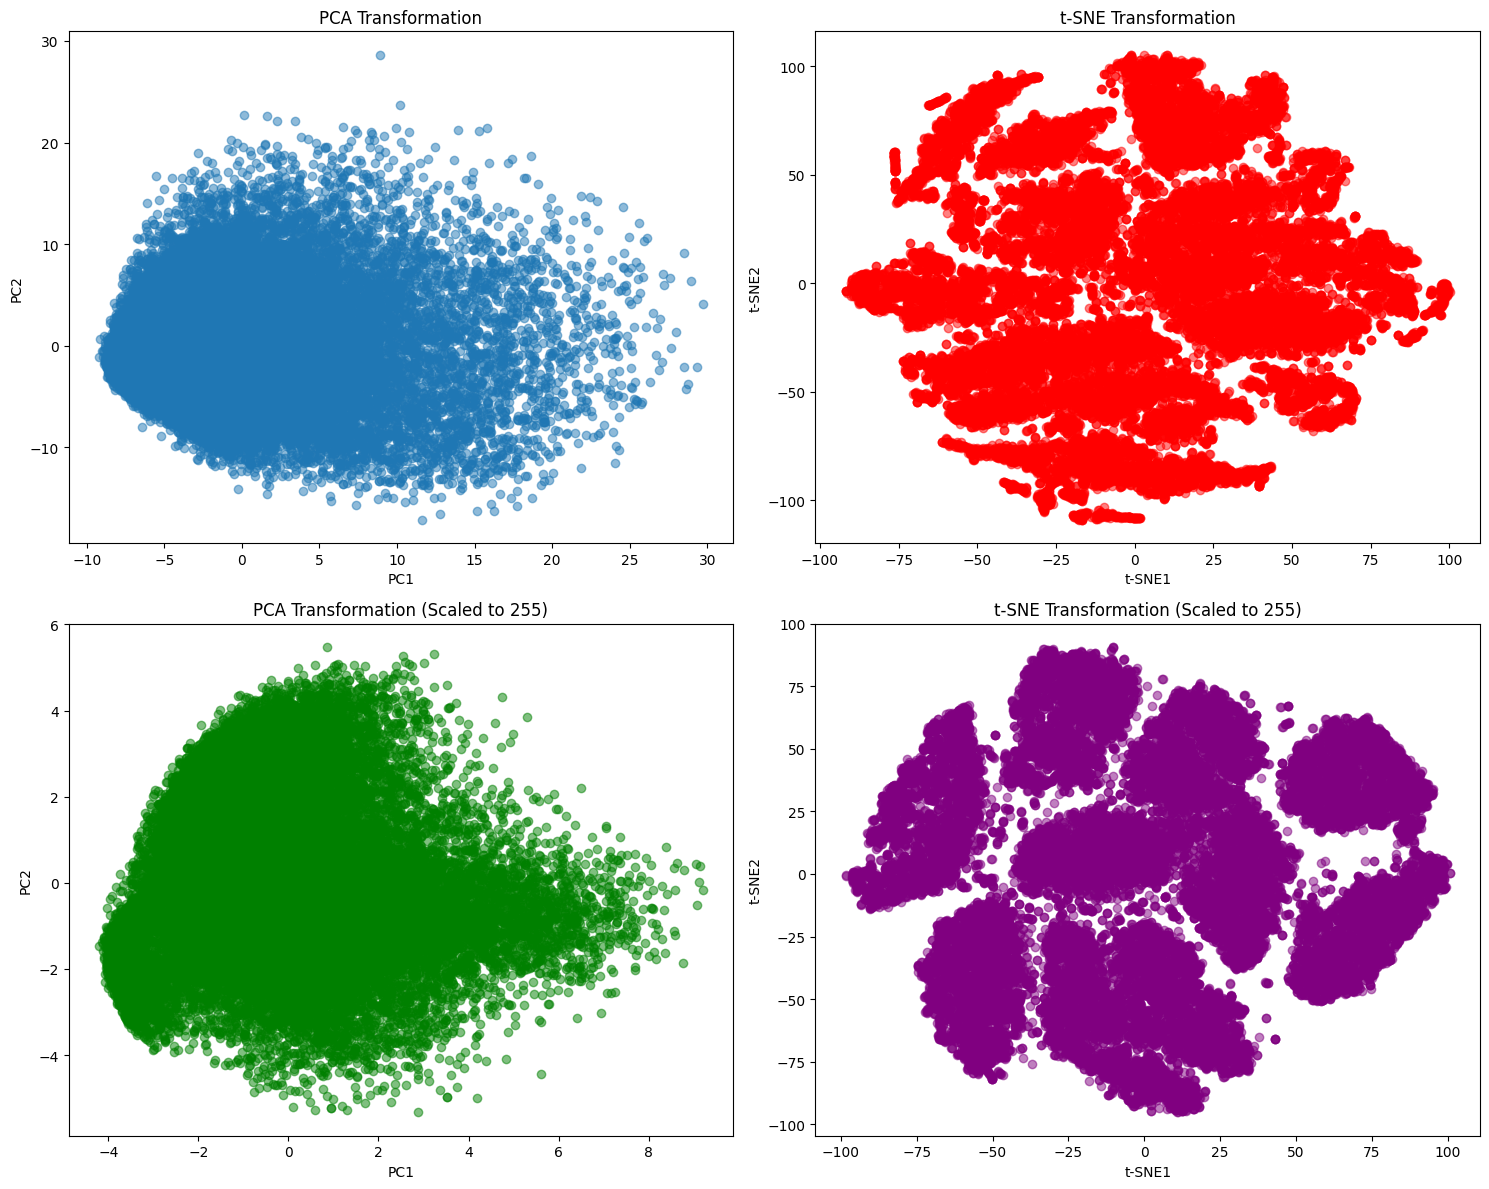

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# PCA without scaling to 255
axs[0, 0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], alpha=0.5)
axs[0, 0].set_title('PCA Transformation')
axs[0, 0].set_xlabel('PC1')
axs[0, 0].set_ylabel('PC2')

# t-SNE without scaling to 255
axs[0, 1].scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], alpha=0.5, color='red')
axs[0, 1].set_title('t-SNE Transformation')
axs[0, 1].set_xlabel('t-SNE1')
axs[0, 1].set_ylabel('t-SNE2')

# PCA with scaling to 255
axs[1, 0].scatter(X_test_pca_255[:, 0], X_test_pca_255[:, 1], alpha=0.5, color='green')
axs[1, 0].set_title('PCA Transformation (Scaled to 255)')
axs[1, 0].set_xlabel('PC1')
axs[1, 0].set_ylabel('PC2')

# t-SNE with scaling to 255
axs[1, 1].scatter(X_test_tsne_255[:, 0], X_test_tsne_255[:, 1], alpha=0.5, color='purple')
axs[1, 1].set_title('t-SNE Transformation (Scaled to 255)')
axs[1, 1].set_xlabel('t-SNE1')
axs[1, 1].set_ylabel('t-SNE2')

plt.tight_layout()
plt.show()


In [17]:
k = 10
n_components = 10
clusters_Kmeans = KMeans(n_clusters=k, random_state=0).fit_predict(X_train_tsne_255)
gmm = GaussianMixture(n_components=n_components, random_state=0,verbose=1).fit(X_train_tsne_255)
clusters_gmm = gmm.predict(X_train_tsne_255)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization 0
Initialization converged: True


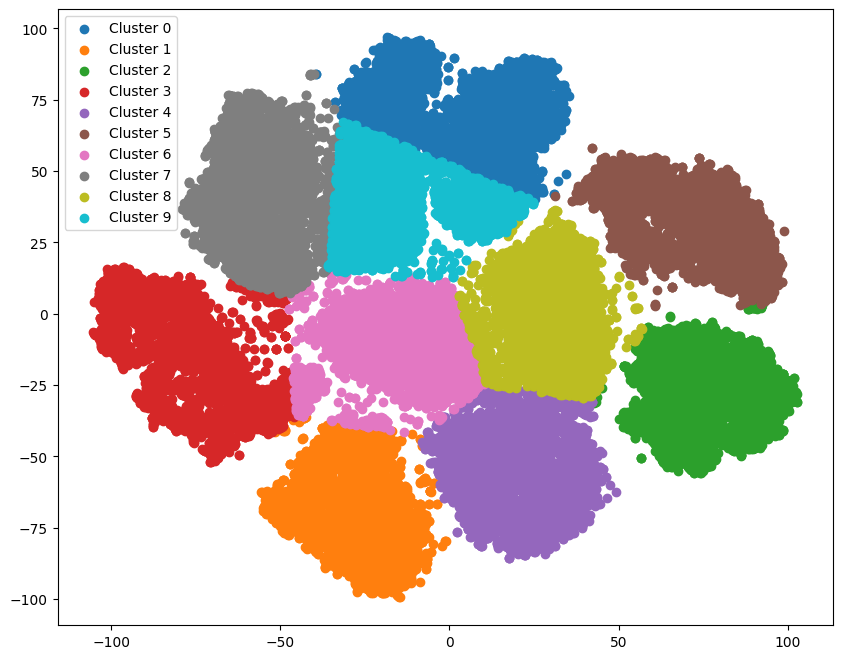

In [18]:
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(X_train_tsne_255[clusters_Kmeans == i, 0], X_train_tsne_255[clusters_Kmeans == i, 1], label=f'Cluster {i}')
plt.legend()
plt.show()

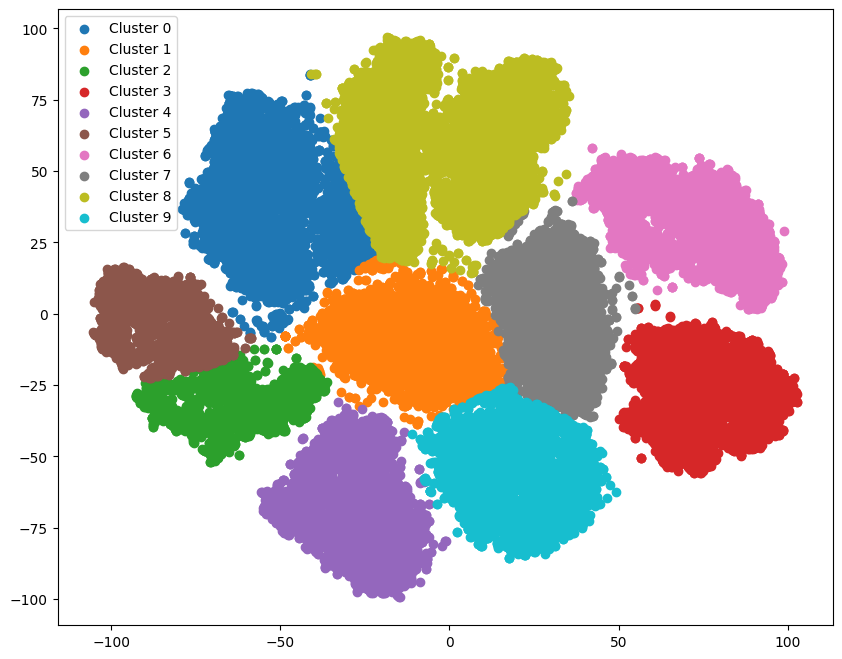

In [19]:
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(X_train_tsne_255[clusters_gmm == i, 0], X_train_tsne_255[clusters_gmm == i, 1], label=f'Cluster {i}')
plt.legend()
plt.show()

In [20]:
k = 20
n_components = 20
clusters_Kmeans = KMeans(n_clusters=k, random_state=0).fit_predict(X_train_tsne_255)
gmm = GaussianMixture(n_components=n_components, random_state=0,verbose=1).fit(X_train_tsne_255)
clusters_gmm = gmm.predict(X_train_tsne_255)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization 0
Initialization converged: True


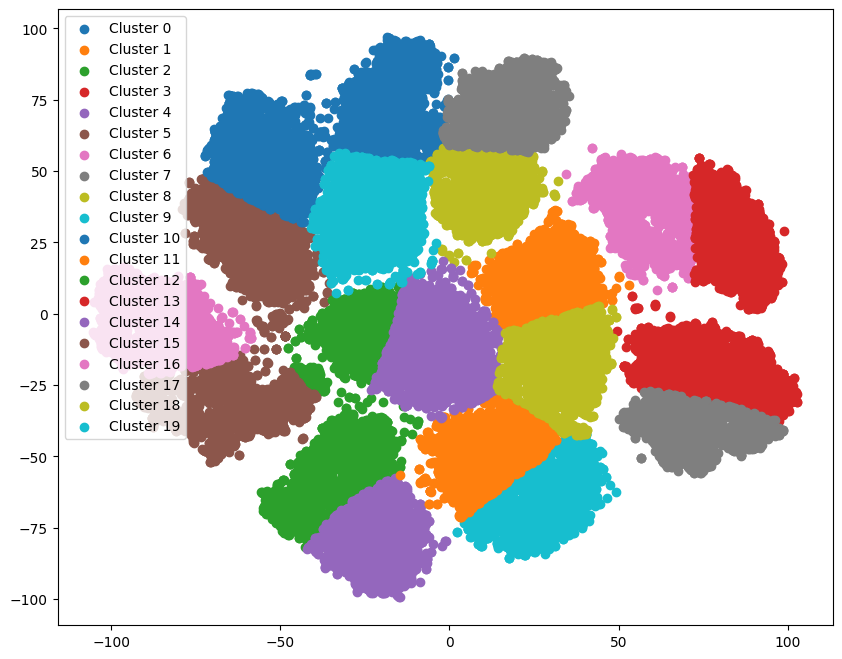

In [21]:
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(X_train_tsne_255[clusters_gmm == i, 0], X_train_tsne_255[clusters_gmm == i, 1], label=f'Cluster {i}')
plt.legend()
plt.show()

In [22]:
k = 30
n_components = 30
clusters_Kmeans = KMeans(n_clusters=k, random_state=0).fit_predict(X_train_tsne_255)
gmm = GaussianMixture(n_components=n_components, random_state=0,verbose=1).fit(X_train_tsne_255)
clusters_gmm = gmm.predict(X_train_tsne_255)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Initialization 0
Initialization converged: True


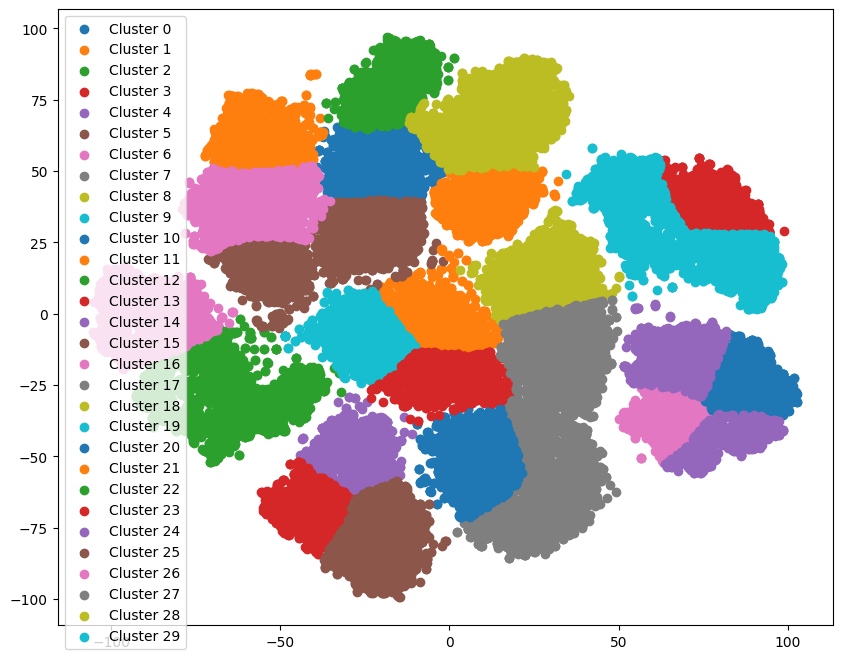

In [23]:
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(X_train_tsne_255[clusters_gmm == i, 0], X_train_tsne_255[clusters_gmm == i, 1], label=f'Cluster {i}')
plt.legend()
plt.show()

In [45]:
def relabeling (k, X_train):
  gmm = GaussianMixture(n_components=k, random_state=0,verbose=1).fit(X_train)
  clusters = gmm.predict(X_train)

  df_clusters = pd.DataFrame({'Actual': y_train, 'Cluster': clusters})
  crosstab = pd.crosstab(df_clusters['Actual'], df_clusters['Cluster'])

  # Initialize the mapping dictionary
  cluster_to_label_mapping = {}

  for cluster_number in crosstab.columns:
      # Get the most common actual label for each cluster
      cluster_to_label_mapping[cluster_number] = crosstab[cluster_number].idxmax()

  # Assuming `predicted_clusters` is a list/array of your predicted cluster numbers
  # Initialize an array to hold the new predicted labels
  predicted_labels = np.zeros_like(clusters_gmm)

  # Map each cluster to the new label
  for cluster, label in cluster_to_label_mapping.items():
      predicted_labels[clusters_gmm == cluster] = label

  accuracy = accuracy_score(y_train, predicted_labels)
  print(f"components: {k},  Accuracy: {accuracy * 100:.2f}%")

  return predicted_labels



In [48]:
for i in range(1,56, 5):
  result_30 = relabeling(i,X_train_tsne_255)
  #print(result_30)

Initialization 0
Initialization converged: True
components: 1,  Accuracy: 9.85%
[0 0 0 ... 0 0 1]
Initialization 0
  Iteration 10
Initialization converged: True
components: 6,  Accuracy: 17.32%
[0 0 0 ... 0 3 9]
Initialization 0
Initialization converged: True
components: 11,  Accuracy: 21.22%
[0 7 0 ... 0 0 9]
Initialization 0
Initialization converged: True
components: 16,  Accuracy: 19.07%
[9 7 0 ... 0 0 9]
Initialization 0
Initialization converged: True
components: 21,  Accuracy: 65.90%
[1 0 1 ... 0 6 9]
Initialization 0
Initialization converged: True
components: 26,  Accuracy: 74.82%
[1 0 1 ... 0 6 9]
Initialization 0
Initialization converged: True
components: 31,  Accuracy: 96.02%
[1 0 1 ... 7 6 9]
Initialization 0
Initialization converged: True
components: 36,  Accuracy: 86.09%
[1 0 1 ... 9 6 7]
Initialization 0
Initialization converged: True
components: 41,  Accuracy: 87.56%
[1 0 1 ... 7 6 9]
Initialization 0
Initialization converged: True
components: 46,  Accuracy: 86.45%
[1 0 1

In [37]:
# Create a DataFrame for easier cross-tabulation

df_clusters = pd.DataFrame({'Actual': y_train, 'Cluster': clusters_gmm})
crosstab = pd.crosstab(df_clusters['Actual'], df_clusters['Cluster'])


In [28]:

# Initialize the mapping dictionary
cluster_to_label_mapping = {}

for cluster_number in crosstab.columns:
    # Get the most common actual label for each cluster
    cluster_to_label_mapping[cluster_number] = crosstab[cluster_number].idxmax()

# Assuming `predicted_clusters` is a list/array of your predicted cluster numbers
# Initialize an array to hold the new predicted labels
predicted_labels = np.zeros_like(clusters_gmm)

# Map each cluster to the new label
for cluster, label in cluster_to_label_mapping.items():
    predicted_labels[clusters_gmm == cluster] = label

# Now `new_predicted_labels` contains the updated label predictions


In [29]:
#print(cluster_to_label_mapping)


{0: 9, 1: 8, 2: 1, 3: 6, 4: 2, 5: 7, 6: 0, 7: 3, 8: 4, 9: 6, 10: 0, 11: 7, 12: 1, 13: 2, 14: 0, 15: 9, 16: 1, 17: 3, 18: 5, 19: 8, 20: 3, 21: 4, 22: 9, 23: 8, 24: 0, 25: 2, 26: 7, 27: 5, 28: 4, 29: 6}


In [49]:
accuracy = accuracy_score(y_train, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Create a DataFrame with actual and predicted labels
updated_df = pd.DataFrame({'Actual': y_train, 'Predicted': predicted_labels})

# Generate the updated cross-tabulation matrix
updated_crosstab = pd.crosstab(updated_df['Actual'], updated_df['Predicted'])



print(updated_crosstab)


Accuracy: 96.02%
Predicted     0     1     2     3     4     5     6     7     8     9
Actual                                                               
0          4100     1     2     0     3     4    18     0     2     2
1             0  4651    10     2     1     0     3     5     4     8
2            31    47  3965    10     2     3     5    84    20    10
3             3    13    22  4121     2    74     3    23    59    31
4             3    47     0     0  3851     0    11     8     1   151
5             8     5     1    60     2  3629    52     3    12    23
6            18     4     1     0     5    21  4086     0     2     0
7             0    68    12     0     3     1     1  4212     1   103
8             8    53     6    59    18    70    20     7  3780    42
9            15    16     2    58    64    13     2    64    20  3934


In [31]:

# Calculate the accuracy


Accuracy: 96.02%


#Discussion and Conclusion
###Project Purpose Revisited
* This project aimed to identify digit values from the MNIST dataset using unsupervised learning techniques. The primary challenge was to discern and categorize these digits without the guidance of labeled training data, relying solely on the inherent patterns and structures within the data.

###Importance of Preprocessing
* Preprocessing emerged as a pivotal step in our analysis. While PCA (Principal Component Analysis) failed to yield clear clusters, the t-SNE (t-Distributed Stochastic Neighbor Embedding) transformation was successful in this regard. This divergence in performance can be attributed to the nature of PCA and t-SNE:

* PCA, typically efficient in dimensionality reduction, may not always be suitable for complex, high-dimensional data like images. PCA focuses on maximizing variance, which does not necessarily equate to preserving the local structure crucial for distinguishing between similar digits.
* t-SNE, conversely, excels in preserving local structures and relationships, making it more adept at capturing the nuances of handwritten digits and forming distinct clusters.
### Performance of Gaussian Mixture Model
* The Gaussian Mixture Model (GMM) demonstrated impressive capabilities in clustering the digit data. GMM's flexibility in handling various cluster shapes and its probabilistic approach contributed significantly to its superior performance over the more rigid K-Means model.

###Optimal Model Complexity
* The model peaked in performance at 31 components, achieving an accuracy of 96%. This suggests an optimal level of complexity, where the model is sufficiently detailed yet not overfitted. Beyond 31 components, the fluctuating accuracy indicates potential overfitting or the model's struggle to meaningfully differentiate between additional clusters.

###Future Improvements
Looking ahead, there are two main avenues for further enhancing this project:

* Exploring Alternative Dimensionality Reduction Techniques: Experimenting with other techniques like UMAP (Uniform Manifold Approximation and Projection) could provide different perspectives on the data structure. UMAP is known for its effectiveness in preserving both local and global data structures and might offer better clustering outcomes than t-SNE in certain scenarios.

* Integrating Supervised Learning Post-Clustering: After establishing clusters through unsupervised methods, applying a supervised learning algorithm to a subset of labeled data could refine the accuracy of digit identification. This semi-supervised approach can harness the strengths of both learning types.



In conclusion, this project underscores the significance of appropriate preprocessing and model selection in unsupervised learning. The success of t-SNE and GMM in this context highlights their potential for similar applications, especially in complex, high-dimensional datasets. Future explorations in this field promise to  harness the power of unsupervised learning in digit recognition and beyond.

In [58]:
test_clusters = gmm.predict(X_test_tsne_255)
print(test_clusters)
# Initialize an array to hold the predicted labels for the test dataset
test_labels = np.zeros_like(test_clusters)

# Use the cluster_to_label_mapping to assign labels to the test dataset's predictions
for cluster in np.unique(test_clusters):
    # Use the mapping to get the predicted label for this cluster
    label = cluster_to_label_mapping.get(cluster, -1)  # Use -1 or another value to indicate unmapped clusters
    test_labels[test_clusters == cluster] = label


# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ImageId': np.arange(1, len(test_labels) + 1),
    'Label': test_labels
})

# Export to CSV for submission
submission_path = '/content/drive/MyDrive/Colab Notebooks/results/DR_submission.csv'
submission_df.to_csv(submission_path, index=False)
print(len(submission_df))
print(submission_df.head(3))

[22 29 23 ... 21 25 22]
28000
   ImageId  Label
0        1      9
1        2      6
2        3      8


In [59]:
submission_df["Label"].value_counts()


6    3189
1    3041
2    3016
9    2874
3    2852
5    2775
7    2649
4    2603
0    2501
8    2500
Name: Label, dtype: int64

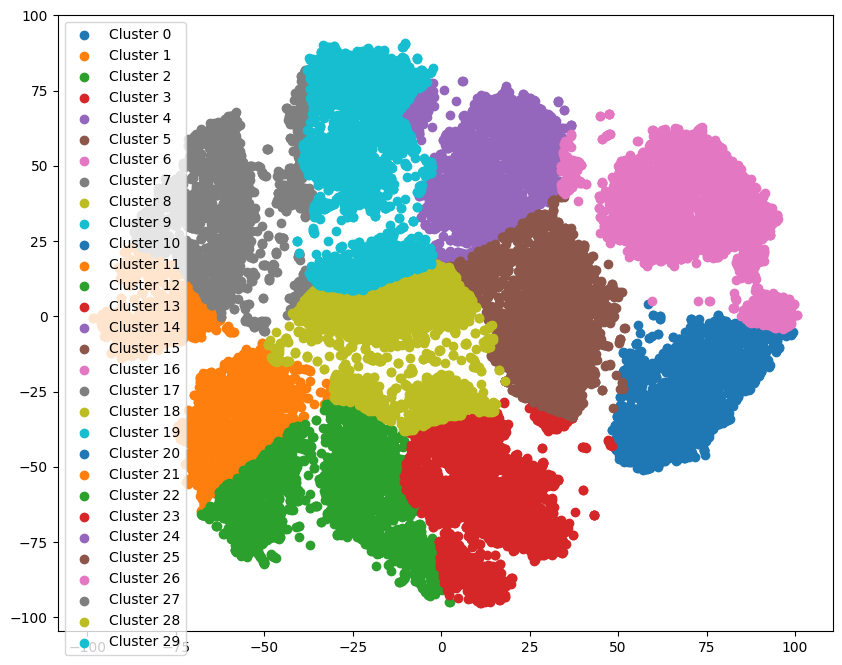

In [60]:
plt.figure(figsize=(10, 8))
for i in range(k):
    plt.scatter(X_test_tsne_255[test_labels == i, 0], X_test_tsne_255[test_labels == i, 1], label=f'Cluster {i}')
plt.legend()
plt.show()

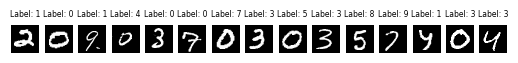

In [71]:
uml_test = test
uml_test['Label']  = submission_df['Label'].values
# Reshape the images and plot them
samples = 15
for i in range(samples):
    image = uml_test.iloc[i, 1:].values.reshape(28, 28)  # Reshape from 1D to 2D
    plt.subplot(2, samples, i+1)  # Create subplots for each image
    plt.imshow(image, cmap='gray')  # Show the image in grayscale
    plt.title(f"Label: {train.iloc[i, 0]}",size =5.5)  # Show the label of the image
    plt.axis('off')  # Turn off the axis

plt.show()  # Display the images


In [100]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Separate features and labels
X = train.iloc[:, 1:].values.reshape(-1, 28, 28, 1) # Reshape for CNN (batch, height, width, channels)
y = train.iloc[:, 0].values

# Normalize the features
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y)

# Splitting data into training and validation set
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [101]:
print(X_train.shape)
print(y_train.shape)

(33600, 28, 28, 1)
(33600, 10)


Mounted at /content/drive


In [ ]:
path  ='/content/drive/MyDrive/Colab Notebooks/DL_Final/'
import joblib

joblib.dump(kmeans, path + 'best_kmeans_model.joblib')  # Saving the model


['/content/drive/MyDrive/Colab Notebooks/DL_Final/best_kmeans_model.joblib']

In [ ]:
kmeans = joblib.load(path + 'best_kmeans_model.joblib')  # Loading the model
